In [237]:
!python --version

Python 3.6.9


In [238]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [239]:
pd.__version__

'1.1.5'

In [240]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [241]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Conv1D, Input, Flatten, Dense, LSTM, Dropout
from tensorflow.keras import Model

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [242]:
tf.__version__

'2.3.0'

Technical indicators: these indicators are widely-used for stock price data. 

In [243]:
## https://stackoverflow.com/questions/57006437/calculate-rsi-indicator-from-pandas-dataframe/57037866
def RSI(df, n=14):
  df = pd.DataFrame(df)
  def rma(x, n, y0):
      a = (n-1) / n
      ak = a**np.arange(len(x)-1, -1, -1)
      return np.append(y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1))

  df['change'] = df.iloc[:].diff()
  df['gain'] = df['change'].mask(df.change < 0, 0.0)
  df['loss'] = -df['change'].mask(df.change > 0, -0.0)
  df.loc[n:,'avg_gain'] = rma( df.loc[n+1:,'gain'].values, n, df.loc[:n, 'gain'].mean())
  df.loc[n:,'avg_loss'] = rma( df.loc[n+1:,'loss'].values, n, df.loc[:n, 'loss'].mean())
  df['rs'] = df.avg_gain / df.avg_loss
  df['rsi_14'] = 100 - (100 / (1 + df['rs']))
  return df['rsi_14']

def weighted_moving_average(df, n=30):
  df = pd.DataFrame(df)
  weights = np.arange(1, n+1)
  res = df.iloc[:].rolling(n).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
  return res

## similar to Moving Average Convergence Divergence (MACD)
def MACD(df, slow=60, fast=10):
  df = pd.DataFrame(df)
  exp1 = df.ewm(span=fast, adjust=False).mean()
  exp2 = df.ewm(span=slow, adjust=False).mean()
  macd = exp1-exp2
  return macd

In [244]:
def create_features(data, name):
    data = data[['datetime', 'level']]
    data['pct_change_1m'] = data['level'].pct_change(periods=1)
    
    data['short_ma'] = data['level'].rolling(window=10).mean()
    data['short_ma_pct_change_baseline'] = (data['short_ma']-data['level'])/data['level']
    data['short_ma_pct_change_10m'] = data['short_ma'].pct_change(periods=10)
    data['short_std'] = data['level'].rolling(window=10).std()
    data['short_std_pct_change_10m'] = data['short_std'].pct_change(periods=10)

    data['long_ma'] = data['level'].rolling(window=60).mean()
    data['long_ma_pct_change_baseline'] = (data['long_ma']-data['level'])/data['level']
    data['long_ma_pct_change_60m'] = data['long_ma'].pct_change(periods=60)
    data['long_std'] = data['level'].rolling(window=60).std()
    data['long_std_pct_change_60m'] = data['long_std'].pct_change(periods=60)

    data['short_ewm'] = data['level'].ewm(span=10, adjust=False).mean()
    data['short_ewm_pct_change_baseline'] = (data['short_ewm']-data['level'])/data['level']

    data['long_ewm'] = data['level'].ewm(span=60, adjust=False).mean()
    data['long_ewm_pct_change_baseline'] = (data['long_ewm']-data['level'])/data['level']

    ## technical indicators
    data['rsi'] = RSI(data['level'], n=30)
    data['wma'] = weighted_moving_average(data['level'], n=30)
    data['wma_pct_change'] = data['wma'].pct_change(periods=1)
    data['macd'] = MACD(data['level'], slow=60, fast=10)

    # data = data.drop(['level', 'short_ma', 'long_ma', 'short_std', 'long_std', 'short_ewm', 'long_ewm'], axis=1)
    # data = data.drop(['level', 'short_ma', 'long_ma', 'short_std', 'long_std'], axis=1)

    rename_mapper = {col: name+'_'+col for col in data.columns[1:]}
    data = data.rename(columns=rename_mapper)
    return data

In [245]:
def create_dataset(data, window_size=5, batch_size=32, shuffle=False):
    data = data.dropna()
    data = data.reset_index()
    data = data.drop(['index', 'datetime'], axis=1)
    # target = np.concatenate((np.zeros(window_size), data['sym_pct_change_1m'][window_size:]))
    target =  data['sym_pct_change_1m']
    x = np.array(data)
    
    ts_dataset = TimeseriesGenerator(x, target, 
                                     length=window_size, 
                                     stride=1,
                                     batch_size=batch_size, 
                                     shuffle=shuffle)
    
    return ts_dataset
    

In [246]:
def train_val_test_split(data, window_size=5, batch_size=32, train_pct=0.7, val_pct=0.2, shuffle=False):
    data = data.dropna()
    n = data.shape[0]
    n_train = int(n*train_pct)
    n_validation = int(n*val_pct)
    n_test = n-n_train-n_validation
    print("number of total data samples", n, "n_train", n_train, "n_validation", n_validation, "n_test", n_test)
    train_data = data.iloc[:n_train].copy()
    validation_data = data.iloc[n_train-window_size:n_train+n_validation].copy()
    test_data = data.iloc[n_train+n_validation-window_size:].copy()
    
    ## feature scaling
    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    train_data.iloc[:, 1:] = scaler.fit_transform(train_data.iloc[:, 1:])
    validation_data.iloc[:, 1:] = scaler.transform(validation_data.iloc[:, 1:])
    test_data.iloc[:, 1:] = scaler.transform(test_data.iloc[:, 1:])

    ## here, we can temporily use (batch_size=1, shuffle=False) to verify that the dataset object is correct
    train_dataset = create_dataset(train_data, window_size=window_size, 
                                   batch_size=batch_size, shuffle=shuffle)
    print("train number of batches", len(train_dataset))
    validation_dataset = create_dataset(validation_data, window_size=window_size, 
                                        batch_size=batch_size, shuffle=shuffle)
    print("validation number of batches", len(validation_dataset))
    test_dataset = create_dataset(test_data, window_size=window_size, 
                                  batch_size=batch_size, shuffle=shuffle)
    print("test number of batches", len(test_dataset))
    
#     i = 0
#     for x, y in train_dataset:
#         assert np.array_equal(x[0], np.array(data.iloc[i:i+window_size, 1:]))
#         assert np.array_equal(y[0], np.array(data.iloc[i+window_size, 1]))
#         i += 1

#     for x, y in validation_dataset:
#         assert np.array_equal(x[0], np.array(data.iloc[i:i+window_size, 1:]))
#         assert np.array_equal(y[0], np.array(data.iloc[i+window_size, 1]))
#         i += 1
    
#     for x, y in test_dataset:
#         assert np.array_equal(x[0], np.array(data.iloc[i:i+window_size, 1:]))
#         assert np.array_equal(y[0], np.array(data.iloc[i+window_size, 1]))
#         i += 1
        
    return train_dataset, validation_dataset, test_dataset, test_data, scaler

Baseline model: use the value from last trade

In [247]:
class Baseline_last_trade(Model):
    def __init__(self, name=None):
        super().__init__()
        self.model_name = 'Baseline_last_trade'

    def call(self, inputs):
        return tf.zeros_like(inputs[:, -1:, 0])

Baseline model class: use moving average from previous trades

In [248]:
class Baseline_ma(Model):
    def __init__(self, ma_index=None):
        super().__init__()
        if ma_index is None:
            raise ValueError('Index of moving average is needed for this baseline model')
        self.ma_index = ma_index

    def call(self, inputs):
        result = inputs[:, -1:, self.ma_index]
        return result

Conv1D model

In [249]:
def get_conv1d_model(input_shape, conv_width=None, filter_size=None):
    if conv_width is None:
        raise ValueError("conv_width is needed as a list of integers")
    if filter_size is None:
        raise ValueError("filter_size is needed as a list of integers")
    if len(conv_width) != len(filter_size):
        raise ValueError("len(conv_width) != filter_size")
    
    input_ = Input(input_shape)
    x = input_
    for width, filters in zip(conv_width, filter_size):
        x = Conv1D(filters=filters, kernel_size=(width,), activation='relu')(x)
        x = Dropout(0.5)(x)

    x = Flatten()(x)
#     x = Dense(64)(x)
    # x = Dense(16)(x)
    output_ = Dense(1)(x)
    model = Model(inputs=input_, outputs=output_)
    model.compile(loss=tf.losses.Huber(delta=0.01),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

LSTM model

In [250]:
def get_LSTM_model(input_shape, units_list=None):
    if units_list is None:
        raise ValueError("units is needed as a list of integers")
    
    input_ = Input(input_shape)
    x = input_
    for units in units_list:
        x = LSTM(units, return_sequences=True, activation='tanh')(x)
        x = Dropout(0.5)(x)
        
    x = LSTM(units_list[-1], activation='tanh')(x)
    x = Dense(units_list[-1])(x)
    output_ = Dense(1)(x)
    model = Model(inputs=input_, outputs=output_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.1),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

Linear regression model: to avoid overfitting, the window_size is reduced

In [251]:
def get_lr_model(input_shape, lr_window_size=5, units_list=None):
    input_ = Input(input_shape)
    x = input_[:, -lr_window_size:, :]
    x = Flatten()(x)
    output_ = Dense(1, kernel_regularizer='l1', bias_regularizer='l1')(x)
    model = Model(inputs=input_, outputs=output_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

Ensemble model #1: simple average

In [252]:
def get_myMajority_model(input_shape, models=None):
    if models is None:
        raise ValueError('models are needed for this ensemble model')
    for model in models:
      model.trainable = False
    input_ = Input(input_shape)
    outputs_ = [model(input_) for model in models]
    outputs_ = tf.stack(outputs_, axis=1)
    outputs_ = Flatten()(outputs_)
    outputs_ = tf.math.reduce_mean(outputs_, axis=1, keepdims=True)
    model = Model(inputs=input_, outputs=outputs_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

Ensemble model #2: learned weighted average

In [253]:
def get_myEnsStack_model(input_shape, models=None):
    if models is None:
        raise ValueError('models are needed for this ensemble model')
    for model in models:
      model.trainable = False
    input_ = Input(input_shape)
    outputs_ = [model(input_) for model in models]
    outputs_ = tf.stack(outputs_, axis=1)
    outputs_ = Flatten()(outputs_)
    outputs_ = Dense(1, use_bias=False)(outputs_)
    model = Model(inputs=input_, outputs=outputs_)
    model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
    return model

The following function helps compute the actual root-mean-square error of our predicted level. Also, the predictions are made one by one to simulate the real-time prediction.

In [254]:
def model_eval(model, data, scaler):
    i = 0
    RMSE_raw = []
    RMSE_pct = []
    RMSE_level = []

    preds_raw = []
    preds_pct = []
    preds_level = []
    for i in range(len(data)-window_size):
      input_ = data.iloc[i:i+window_size, 1:]
      input_ = scaler.transform(input_)
      # print(input_[0])
      input_ = tf.expand_dims(input_, axis=0)

      last_row = data.iloc[i+window_size-1, 1:]
      last_price = last_row[0]

      target_row = np.array(data.iloc[i+window_size, 1:])
      target_row = np.expand_dims(target_row, axis=0)
      transformed_target_row = scaler.transform(target_row)
      transformed_target = transformed_target_row[:, 1]
      target_level = target_row[:, 0]
      target_pct = target_row[:, 1]
      
      transformed_pred_pct = model(input_).numpy()[0, 0]
      transformed_pred_row = np.zeros_like(target_row)
      transformed_pred_row[:, 1] = transformed_pred_pct
      pred_row = scaler.inverse_transform(transformed_pred_row)

      if hasattr(model, 'model_name') and model.model_name == 'Baseline_last_trade':
        pred_pct = np.array([0.0])
      else:
        pred_pct = pred_row[:, 1]

      pred_level = last_price * (1+pred_pct)
      preds_pct.append(pred_pct)
      preds_level.append(pred_level)

      RMSE_raw.append(tf.math.squared_difference(transformed_target.astype('float32'), transformed_pred_pct.astype('float32')))
      RMSE_pct.append(tf.math.squared_difference(target_pct.astype('float32'), pred_pct.astype('float32')))
      RMSE_level.append(tf.math.squared_difference(target_level.astype('float32'), pred_level.astype('float32')))

      rmse_raw = tf.math.sqrt(tf.math.reduce_mean(RMSE_raw)).numpy()
      rmse_pct = tf.math.sqrt(tf.math.reduce_mean(RMSE_pct)).numpy()
      rmse_level = tf.math.sqrt(tf.math.reduce_mean(RMSE_level)).numpy()
      # break
      
    return rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level

# Load data

In [255]:
file_path = "/content/gdrive/My Drive/Colab Notebooks/project_modeling_test/bond_spreads.csv"
data = pd.read_csv(file_path, index_col=0)
data['datetime'] = pd.to_datetime(data['datetime'])
data.sort_values(by='datetime')
data.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,datetime,sym,level
0,2020-11-01 08:00:00,US0ATXMR1KXH,135.484079
1,2020-11-01 08:00:00,US1Q9L9LWF70,134.431820
2,2020-11-01 08:00:00,US6KJNEMVUB3,173.589274
3,2020-11-01 08:00:00,USVB60AAKLSG,168.731458
4,2020-11-01 08:00:00,US0GLYO7VCOH,81.383554


In [256]:
df_sym_to_sector = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/project_modeling_test/sym_to_sector.csv')
# df_sym_to_sector.head()
df_sym_to_sector['sector'].value_counts()

CONSUMER_CYCLICALS    512
INDUSTRIALS           330
ENERGY                311
TECHNOLOGY            292
Name: sector, dtype: int64

In [257]:
df_sym_to_issuer = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/project_modeling_test/sym_to_issuer.csv')
df_sym_to_issuer['issuer'].value_counts()

ECH     94
HGJU    94
XOY     93
X       87
TA      86
F       85
J       73
EEQ     60
ZBPY    55
T       53
FV      50
D       42
OERT    41
RY      40
NL      40
YVPO    39
U       39
MH      38
Q       36
LFU     31
XPHX    30
LGK     29
XG      29
XZET    26
EJMR    23
TOT     20
C       18
VYIV    15
NMYQ    13
RYDM    13
B       10
I        8
AH       8
SPW      7
XRC      5
KNRI     4
WNR      4
M        2
GV       2
GK       1
OFR      1
TT       1
Name: issuer, dtype: int64

In [258]:
raw_data = data.merge(df_sym_to_sector, on='sym')
raw_data = raw_data.merge(df_sym_to_issuer, on='sym')
raw_data.head()

,datetime,sym,level,sector,issuer
0,2020-11-01 08:00:00,US0ATXMR1KXH,135.484079,CONSUMER_CYCLICALS,XOY
1,2020-11-01 08:01:00,US0ATXMR1KXH,133.008120,CONSUMER_CYCLICALS,XOY
2,2020-11-01 08:02:00,US0ATXMR1KXH,133.269386,CONSUMER_CYCLICALS,XOY
3,2020-11-01 08:03:00,US0ATXMR1KXH,132.534590,CONSUMER_CYCLICALS,XOY
4,2020-11-01 08:04:00,US0ATXMR1KXH,134.908804,CONSUMER_CYCLICALS,XOY


In [259]:
syms_all = raw_data['sym'].unique()
syms_all

array(['US0ATXMR1KXH', 'US1Q9L9LWF70', 'US6KJNEMVUB3', ...,
       'USL3W14NOS6O', 'USOYXI6CIQ2M', 'USS7E04EJOAJ'], dtype=object)

Select a target sym

In [260]:
sym = 'USV9CQ7RNR6Y'
# sym = np.random.choice(syms_all, 1)[0]
sym_data = raw_data[raw_data['sym']==sym].reset_index().drop('index', axis=1)
sym_data.head()

,datetime,sym,level,sector,issuer
0,2020-11-01 08:00:00,USV9CQ7RNR6Y,352.071816,ENERGY,ECH
1,2020-11-01 08:01:00,USV9CQ7RNR6Y,350.556741,ENERGY,ECH
2,2020-11-01 08:02:00,USV9CQ7RNR6Y,350.725177,ENERGY,ECH
3,2020-11-01 08:05:00,USV9CQ7RNR6Y,351.692869,ENERGY,ECH
4,2020-11-01 08:06:00,USV9CQ7RNR6Y,351.923203,ENERGY,ECH


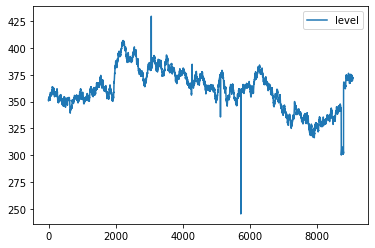

In [261]:
sym_data.plot(y='level')

Get sector and issuer data of this bond

1.   Compute the average price of the sector
2.   Compute the average price of the issuer

The intuition is: the bonds in the same sector or from the same issuer may provide some information for prediction of this bond. For example, the momentum of the aggregated price data can be informative to our model. 



In [262]:
sec = sym_data.loc[0, 'sector']
sec_data = raw_data[raw_data['sector']==sec]
sec_avg_price_data = sec_data.groupby(by='datetime').mean()
sec_avg_price_data = sec_avg_price_data.reset_index()
sec_avg_price_data.head()

,datetime,level
0,2020-11-01 08:00:00,111.356382
1,2020-11-01 08:01:00,108.469130
2,2020-11-01 08:02:00,108.620382
3,2020-11-01 08:03:00,107.428109
4,2020-11-01 08:04:00,108.378047


In [263]:
iss = sym_data.loc[0, 'issuer']
iss_data = raw_data[raw_data['issuer']==iss]
iss_avg_price_data = iss_data.groupby(by='datetime').mean()
iss_avg_price_data = iss_avg_price_data.reset_index()
iss_avg_price_data.head()

,datetime,level
0,2020-11-01 08:00:00,118.409735
1,2020-11-01 08:01:00,119.734964
2,2020-11-01 08:02:00,121.233155
3,2020-11-01 08:03:00,114.618193
4,2020-11-01 08:04:00,115.389790



#### Data usage: train_data: 70%, validation_data: 20%, test_data: 10%; in chronological order

In [264]:
train_pct=0.7
val_pct=0.2
# shuffle = False 
## here, we do not shuffle data during training, validation, testing; 
## it is easier to debug
## after debugging, it can be set to true
shuffle = True 

# Create features and targets, dataset (generotor)
Using sym, sector, issuer data

In [265]:
sym_feature_data = create_features(data=sym_data, name='sym')
sec_feature_data = create_features(data=sec_avg_price_data, name='sec')
issuer_feature_data = create_features(data=iss_avg_price_data, name='iss')

sym_feature_data.shape, sec_feature_data.shape, issuer_feature_data.shape

((9081, 21), (10000, 21), (10000, 21))

In [266]:
feature_data = sym_feature_data.merge(sec_feature_data, on='datetime')
feature_data = feature_data.merge(issuer_feature_data, on='datetime')
feature_data.dropna().head()

,datetime,sym_level,sym_pct_change_1m,sym_short_ma,sym_short_ma_pct_change_baseline,sym_short_ma_pct_change_10m,sym_short_std,sym_short_std_pct_change_10m,sym_long_ma,sym_long_ma_pct_change_baseline,sym_long_ma_pct_change_60m,sym_long_std,sym_long_std_pct_change_60m,sym_short_ewm,sym_short_ewm_pct_change_baseline,sym_long_ewm,sym_long_ewm_pct_change_baseline,sym_rsi,sym_wma,sym_wma_pct_change,sym_macd,sec_level,sec_pct_change_1m,sec_short_ma,sec_short_ma_pct_change_baseline,sec_short_ma_pct_change_10m,sec_short_std,sec_short_std_pct_change_10m,sec_long_ma,sec_long_ma_pct_change_baseline,sec_long_ma_pct_change_60m,sec_long_std,sec_long_std_pct_change_60m,sec_short_ewm,sec_short_ewm_pct_change_baseline,sec_long_ewm,sec_long_ewm_pct_change_baseline,sec_rsi,sec_wma,sec_wma_pct_change,sec_macd,iss_level,iss_pct_change_1m,iss_short_ma,iss_short_ma_pct_change_baseline,iss_short_ma_pct_change_10m,iss_short_std,iss_short_std_pct_change_10m,iss_long_ma,iss_long_ma_pct_change_baseline,iss_long_ma_pct_change_60m,iss_long_std,iss_long_std_pct_change_60m,iss_short_ewm,iss_short_ewm_pct_change_baseline,iss_long_ewm,iss_long_ewm_pct_change_baseline,iss_rsi,iss_wma,iss_wma_pct_change,iss_macd
119,2020-11-01 10:08:00,363.025445,-0.001783,362.101787,-0.002544,0.006819,1.444551,0.120024,358.287132,-0.013052,0.012976,2.269223,0.236285,362.331840,-0.001911,358.710578,-0.011886,62.236336,360.980070,0.000590,3.621262,114.915251,0.005788,113.657239,-0.010947,0.020301,1.338272,0.104170,108.852665,-0.052757,0.007424,3.038142,0.382714,113.677289,-0.010773,110.057192,-0.042275,56.857268,112.385105,0.002275,3.620097,124.721856,0.023202,121.485079,-0.025952,0.018431,2.480259,0.011981,117.750473,-0.055895,-0.002283,2.962006,0.037873,121.663390,-0.024522,118.758964,-0.047810,53.932622,120.382416,0.002915,2.904427
120,2020-11-01 10:09:00,362.074385,-0.002620,362.297772,0.000617,0.006959,1.267018,0.015152,358.353043,-0.010278,0.012874,2.321118,0.215685,362.285030,0.000582,358.820867,-0.008986,59.041655,361.117292,0.000380,3.464163,111.655032,-0.028371,113.532414,0.016814,0.017749,1.468307,0.128190,108.896738,-0.024704,0.007990,3.059577,0.399902,113.309606,0.014819,110.109581,-0.013841,51.996163,112.413791,0.000255,3.200025,120.272341,-0.035676,121.199367,0.007708,0.015785,2.433918,-0.026235,117.796645,-0.020584,-0.001358,2.979607,0.055820,121.410472,0.009463,118.808583,-0.012170,50.940639,120.428189,0.000380,2.601890
121,2020-11-01 10:10:00,362.010268,-0.000177,362.510391,0.001382,0.007143,0.957583,-0.169164,358.419781,-0.009918,0.012707,2.368062,0.222576,362.235073,0.000621,358.925437,-0.008521,58.831043,361.240511,0.000341,3.309636,112.960841,0.011695,113.550614,0.005221,0.015961,1.459027,0.113615,108.998000,-0.035082,0.009121,3.092240,0.411632,113.246194,0.002526,110.203065,-0.024414,53.638501,112.516223,0.000911,3.043130,122.559112,0.019013,121.382799,-0.009598,0.013702,2.463124,0.063716,117.909144,-0.037941,0.000461,3.030292,0.087511,121.619316,-0.007668,118.931551,-0.029598,52.346165,120.610911,0.001517,2.687765
122,2020-11-01 10:11:00,361.319092,-0.001909,362.534750,0.003365,0.006398,0.919362,-0.094040,358.489630,-0.007831,0.012599,2.391015,0.236186,362.068531,0.002074,359.003918,-0.006408,56.580309,361.310325,0.000193,3.064613,113.695553,0.006504,113.745660,0.000441,0.016311,1.314007,0.102077,109.148681,-0.039992,0.011583,3.097279,0.417969,113.327896,-0.003234,110.317572,-0.029711,54.543696,112.655661,0.001239,3.010323,120.730867,-0.014917,121.684028,0.007895,0.015014,2.126393,0.005007,117.969370,-0.022873,0.001454,3.050131,0.102783,121.457780,0.006021,118.990545,-0.014415,51.134546,120.660118,0.000408,2.467235
123,2020-11-01 10:13:00,360.276200,-0.002886,362.441244,0.006009,0.005233,1.098940,0.635582,358.538977,-0.004822,0.012470,2.396915,0.225941,361.742653,0.004070,359.045632,-0.003416,53.391947,361.304284,-0.000017,2.697021,111.272375,-0.009749,113.392419,0.019053,0.011744,1.446497,-0.028156,109.312123,-0.017617,0.014646,3.106290,0.507676,112.811346

In [267]:
feature_data.shape

(9081, 61)

In [268]:
col_idx_map = {col: idx for idx, col in enumerate(feature_data.columns)}
# col_idx_map

#### Target variable: sym_pct_change_1m
We aim to predict the next-minute level, and the actual target variable is the percentage change of the next-minute level compared to current time (minute). 


sym_pct_change_1m (target) is stationary via test. 

In [269]:
result = adfuller(feature_data['sym_pct_change_1m'].dropna())
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -58.21697210501099
p-value: 0.0
Critical Values:
	1%: -3.4310707085122814
	5%: -2.861858506720047
	10%: -2.566939536083911


In [270]:
window_size = 20
batch_size = 32
feature_dim = feature_data.shape[1]-1

In [271]:
train_dataset, validation_dataset, test_dataset, test_data, scaler = train_val_test_split(feature_data, 
                                                                                          window_size=window_size, 
                                                                                          batch_size=batch_size,
                                                                                          train_pct=train_pct, 
                                                                                          val_pct=val_pct,
                                                                                          shuffle=shuffle)
## scaler: used to do feature scaling, and to transform data in model evaluation


number of total data samples 8962 n_train 6273 n_validation 1792 n_test 897
train number of batches 196
validation number of batches 56
test number of batches 29


### check the correctness of our created dataset object

In [272]:
transformed_feature_data = feature_data.dropna().copy()
transformed_feature_data.iloc[:, 1:] = scaler.transform(feature_data.dropna().iloc[:, 1:])
transformed_feature_data.head(1)

,datetime,sym_level,sym_pct_change_1m,sym_short_ma,sym_short_ma_pct_change_baseline,sym_short_ma_pct_change_10m,sym_short_std,sym_short_std_pct_change_10m,sym_long_ma,sym_long_ma_pct_change_baseline,sym_long_ma_pct_change_60m,sym_long_std,sym_long_std_pct_change_60m,sym_short_ewm,sym_short_ewm_pct_change_baseline,sym_long_ewm,sym_long_ewm_pct_change_baseline,sym_rsi,sym_wma,sym_wma_pct_change,sym_macd,sec_level,sec_pct_change_1m,sec_short_ma,sec_short_ma_pct_change_baseline,sec_short_ma_pct_change_10m,sec_short_std,sec_short_std_pct_change_10m,sec_long_ma,sec_long_ma_pct_change_baseline,sec_long_ma_pct_change_60m,sec_long_std,sec_long_std_pct_change_60m,sec_short_ewm,sec_short_ewm_pct_change_baseline,sec_long_ewm,sec_long_ewm_pct_change_baseline,sec_rsi,sec_wma,sec_wma_pct_change,sec_macd,iss_level,iss_pct_change_1m,iss_short_ma,iss_short_ma_pct_change_baseline,iss_short_ma_pct_change_10m,iss_short_std,iss_short_std_pct_change_10m,iss_long_ma,iss_long_ma_pct_change_baseline,iss_long_ma_pct_change_60m,iss_long_std,iss_long_std_pct_change_60m,iss_short_ewm,iss_short_ewm_pct_change_baseline,iss_long_ewm,iss_long_ewm_pct_change_baseline,iss_rsi,iss_wma,iss_wma_pct_change,iss_macd
119,2020-11-01 10:08:00,-0.409749,-0.228713,-0.480381,-0.368388,1.065232,0.185733,-0.096233,-0.765079,-1.107767,0.844292,-0.215232,0.008204,-0.464273,-0.313235,-0.7405,-1.122799,1.503382,-0.563976,1.045834,1.406059,0.576572,0.188202,0.478003,-0.519504,0.912,-1.087625,0.04371,0.038246,-1.427269,0.094009,0.086016,0.730365,0.480469,-0.585218,0.156302,-1.28383,2.257337,0.36399,1.150555,1.474062,0.104436,0.472405,-0.154284,-0.839599,0.803907,-1.043646,-0.143558,-0.490641,-1.359468,-0.116184,-1.593166,0.023599,-0.140781,-0.888204,-0.403878,-1.250266,1.952112,-0.252542,1.18949,1.121424


In [273]:
if shuffle==False:
  for x, y in train_dataset:
      print("x.shape: (batch_size, window_size, feature_dimension)", x.shape)
      print("y.shape:", y.shape)
      init_idx = feature_data.dropna().index[0]
      transformed_row = np.array(scaler.transform(feature_data.iloc[init_idx:init_idx+window_size, 1:]))
      print("The first time step in the first sample:")
      print(x[0, 0, :])
      assert np.array_equal(x[0], transformed_row)
      target_row = np.array(feature_data.iloc[init_idx+window_size, 1:])
      target_row = scaler.transform(target_row[np.newaxis, :]) 
      assert np.array_equal(y[0], np.array(target_row[0, 1]))
      break

# Create, train and test models
The root_mean_squared_error presented here is computed based on the transformed target (percentage change of the next minute), which is not the RMSE of the predicted level of the next minute. The final evaluation of the models will be presented later. 



Baseline model #1: use the value from last trade

In [274]:
baseline_last_trade_model = Baseline_last_trade()
baseline_last_trade_model.compile(loss=tf.losses.MeanSquaredError(),
                                  metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
baseline_last_trade_model.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 2ms/step - loss: 1.5754 - mean_absolute_error: 0.2920 - root_mean_squared_error: 1.2551


[1.575355711039798, 0.2919536098167227, 1.2551317392119767]

Baseline model #2: use the short-term moving average from previous trades

In [275]:
baseline_st_ma = Baseline_ma(ma_index=col_idx_map['sym_short_ma_pct_change_baseline']-1) ## short-term moving average

baseline_st_ma.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
baseline_st_ma.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 2ms/step - loss: 3.5554 - mean_absolute_error: 0.6997 - root_mean_squared_error: 1.8856


[3.555419055552318, 0.6997337417512067, 1.8855818823203374]

Baseline model #3: use the long-term moving average from previous trades

In [276]:
baseline_lt_ma = Baseline_ma(ma_index=col_idx_map['sym_long_ma_pct_change_baseline']-1) ## long-term moving average

baseline_lt_ma.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
baseline_lt_ma.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 3ms/step - loss: 9.9349 - mean_absolute_error: 1.4784 - root_mean_squared_error: 3.1520


[9.934871737299295, 1.4783711021648054, 3.1519631733139057]

Conv1D model

In [277]:
conv1d_model = get_conv1d_model(input_shape=(window_size, feature_dim), 
                                conv_width=[10, 5, 2, 2], 
                                filter_size=[64, 64, 32, 16])
conv1d_model.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 20, 60)]          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 11, 64)            38464     
_________________________________________________________________
dropout_24 (Dropout)         (None, 11, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 7, 64)             20544     
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 6, 32)             4128      
_________________________________________________________________
dropout_26 (Dropout)         (None, 6, 32)           

In [278]:
# # print('Input shape:', (window_size, 10))
# for x, y in train_dataset:
#     print('Input shape:', x.shape)
#     output_ = conv1d_model(x)
#     print('Output shape:', output_.shape)
#     print("Label shapre:", y.shape)
#     break


In [279]:
history = conv1d_model.fit(train_dataset, 
                            epochs=50, 
                            steps_per_epoch=len(train_dataset),
                            validation_data=validation_dataset, 
                            validation_steps=len(validation_dataset),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=2)],
                            verbose=2)

Epoch 1/50
196/196 - 1s - loss: 0.0036 - mean_absolute_error: 0.3675 - root_mean_squared_error: 1.1982 - val_loss: 0.0024 - val_mean_absolute_error: 0.2445 - val_root_mean_squared_error: 0.3055
Epoch 2/50
196/196 - 1s - loss: 0.0027 - mean_absolute_error: 0.2702 - root_mean_squared_error: 1.2494 - val_loss: 0.0024 - val_mean_absolute_error: 0.2423 - val_root_mean_squared_error: 0.3057
Epoch 3/50
196/196 - 1s - loss: 0.0025 - mean_absolute_error: 0.2572 - root_mean_squared_error: 1.0197 - val_loss: 0.0024 - val_mean_absolute_error: 0.2444 - val_root_mean_squared_error: 0.3065


In [280]:
conv1d_model.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.2706 - root_mean_squared_error: 0.9168


[0.0026564238320008434, 0.27059751610089644, 0.9167862184896498]

LSTM model

In [281]:
LSTM_model = get_LSTM_model(input_shape=(window_size, feature_dim),
                               units_list=[64, 64, 32, 16])
LSTM_model.summary()


Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 20, 60)]          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 20, 64)            32000     
_________________________________________________________________
dropout_28 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
dropout_29 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 20, 32)            12416     
_________________________________________________________________
dropout_30 (Dropout)         (None, 20, 32)          

In [282]:
history = LSTM_model.fit(train_dataset, 
                          epochs=20, 
                          steps_per_epoch=len(train_dataset),
                          validation_data=validation_dataset, 
                          validation_steps=len(validation_dataset),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)],
                          verbose=2)

Epoch 1/20
196/196 - 5s - loss: 0.0725 - mean_absolute_error: 0.2645 - root_mean_squared_error: 0.7657 - val_loss: 0.0459 - val_mean_absolute_error: 0.2398 - val_root_mean_squared_error: 0.3029
Epoch 2/20
196/196 - 3s - loss: 0.0570 - mean_absolute_error: 0.2406 - root_mean_squared_error: 0.8312 - val_loss: 0.0471 - val_mean_absolute_error: 0.2395 - val_root_mean_squared_error: 0.3071
Epoch 3/20
196/196 - 3s - loss: 0.0554 - mean_absolute_error: 0.2407 - root_mean_squared_error: 0.5152 - val_loss: 0.0462 - val_mean_absolute_error: 0.2448 - val_root_mean_squared_error: 0.3041
Epoch 4/20
196/196 - 3s - loss: 0.0637 - mean_absolute_error: 0.2516 - root_mean_squared_error: 0.8330 - val_loss: 0.0484 - val_mean_absolute_error: 0.2468 - val_root_mean_squared_error: 0.3112


In [283]:
LSTM_model.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 6ms/step - loss: 0.0888 - mean_absolute_error: 0.2833 - root_mean_squared_error: 1.0427


[0.0887708958109905, 0.2833117173047104, 1.0427267768436501]

Linear regression model

In [284]:
my_lr_model = get_lr_model(input_shape=(window_size, feature_dim))
my_lr_model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 20, 60)]          0         
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 5, 60)]           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 301       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [285]:
history = my_lr_model.fit(train_dataset, 
                          epochs=20, 
                          steps_per_epoch=len(train_dataset),
                          validation_data=validation_dataset, 
                          validation_steps=len(validation_dataset),
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=3)],
                          verbose=2)

Epoch 1/20
196/196 - 1s - loss: 0.1730 - mean_absolute_error: 0.3328 - root_mean_squared_error: 0.5552 - val_loss: 0.0962 - val_mean_absolute_error: 0.3175 - val_root_mean_squared_error: 0.4029
Epoch 2/20
196/196 - 1s - loss: 0.1167 - mean_absolute_error: 0.3305 - root_mean_squared_error: 1.1356 - val_loss: 0.1499 - val_mean_absolute_error: 0.4193 - val_root_mean_squared_error: 0.5215
Epoch 3/20
196/196 - 1s - loss: 0.1393 - mean_absolute_error: 0.3456 - root_mean_squared_error: 1.3781 - val_loss: 0.1057 - val_mean_absolute_error: 0.3184 - val_root_mean_squared_error: 0.4035
Epoch 4/20
196/196 - 1s - loss: 0.1087 - mean_absolute_error: 0.3170 - root_mean_squared_error: 0.8980 - val_loss: 0.2161 - val_mean_absolute_error: 0.5333 - val_root_mean_squared_error: 0.6464


In [286]:
my_lr_model.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 3ms/step - loss: 0.1846 - mean_absolute_error: 0.4624 - root_mean_squared_error: 0.9021


[0.1845934042109283, 0.46237040096951904, 0.9020662619102711]

Majority-voting model (simple averaging) uses the above two models: conv1d and LSTM.







In [287]:
maj_model = get_myMajority_model(input_shape=(window_size, feature_dim), models=[conv1d_model, LSTM_model])
maj_model.summary() ## no trainable parameters

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 20, 60)]     0                                            
__________________________________________________________________________________________________
functional_31 (Functional)      (None, 1)            64257       input_19[0][0]                   
__________________________________________________________________________________________________
functional_33 (Functional)      (None, 1)            82977       input_19[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_stack_6 (TensorFlow [(None, 2, 1)]       0           functional_31[0][0]              
                                                                 functional_33[0][0]  

In [288]:
maj_model.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 10ms/step - loss: 0.0753 - mean_absolute_error: 0.2735 - root_mean_squared_error: 0.9163


[0.07525185431385863, 0.27354132106075096, 0.9162808176758047]

The ensemble model (weighted averaging) uses the above two models: conv1d and LSTM.


In [289]:
# ensStack_model = get_myEnsStack_model(input_shape=(window_size, feature_dim), models=[my_lr_model, conv1d_model, LSTM_model])
ensStack_model = get_myEnsStack_model(input_shape=(window_size, feature_dim), models=[conv1d_model, LSTM_model])
ensStack_model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 20, 60)]     0                                            
__________________________________________________________________________________________________
functional_31 (Functional)      (None, 1)            64257       input_20[0][0]                   
__________________________________________________________________________________________________
functional_33 (Functional)      (None, 1)            82977       input_20[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_stack_7 (TensorFlow [(None, 2, 1)]       0           functional_31[1][0]              
                                                                 functional_33[1][0]  

In [290]:
history = ensStack_model.fit(train_dataset, 
                            epochs=50, 
                            steps_per_epoch=len(train_dataset),
                            validation_data=validation_dataset, 
                            validation_steps=len(validation_dataset),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=2)],
                            verbose=2)

Epoch 1/50
196/196 - 3s - loss: 0.0576 - mean_absolute_error: 0.2447 - root_mean_squared_error: 0.6711 - val_loss: 0.0485 - val_mean_absolute_error: 0.2523 - val_root_mean_squared_error: 0.3114
Epoch 2/50
196/196 - 2s - loss: 0.0580 - mean_absolute_error: 0.2435 - root_mean_squared_error: 0.6893 - val_loss: 0.0484 - val_mean_absolute_error: 0.2465 - val_root_mean_squared_error: 0.3114
Epoch 3/50
196/196 - 2s - loss: 0.0731 - mean_absolute_error: 0.2583 - root_mean_squared_error: 1.1835 - val_loss: 0.0476 - val_mean_absolute_error: 0.2461 - val_root_mean_squared_error: 0.3086
Epoch 4/50
196/196 - 2s - loss: 0.0667 - mean_absolute_error: 0.2510 - root_mean_squared_error: 1.0747 - val_loss: 0.0445 - val_mean_absolute_error: 0.2379 - val_root_mean_squared_error: 0.2985
Epoch 5/50
196/196 - 2s - loss: 0.0542 - mean_absolute_error: 0.2360 - root_mean_squared_error: 0.5368 - val_loss: 0.0443 - val_mean_absolute_error: 0.2350 - val_root_mean_squared_error: 0.2975
Epoch 6/50
196/196 - 2s - loss

In [291]:
ensStack_model.evaluate(test_dataset, steps=len(test_dataset))

29/29 [==============================] - 0s 7ms/step - loss: 0.0620 - mean_absolute_error: 0.2577 - root_mean_squared_error: 0.5869


[0.062035888754602135, 0.2577401158653403, 0.586855239042349]

# Model evaluation
Here, we will compute the actual root-mean-square error of our predicted level. Also, the predictions are made one by one to simulate the real-time prediction (see the definition of model_eval). 

In [292]:
raw_test_data = feature_data.iloc[-len(test_data):,:].reset_index().drop('index', axis=1)
raw_test_data.head()

,datetime,sym_level,sym_pct_change_1m,sym_short_ma,sym_short_ma_pct_change_baseline,sym_short_ma_pct_change_10m,sym_short_std,sym_short_std_pct_change_10m,sym_long_ma,sym_long_ma_pct_change_baseline,sym_long_ma_pct_change_60m,sym_long_std,sym_long_std_pct_change_60m,sym_short_ewm,sym_short_ewm_pct_change_baseline,sym_long_ewm,sym_long_ewm_pct_change_baseline,sym_rsi,sym_wma,sym_wma_pct_change,sym_macd,sec_level,sec_pct_change_1m,sec_short_ma,sec_short_ma_pct_change_baseline,sec_short_ma_pct_change_10m,sec_short_std,sec_short_std_pct_change_10m,sec_long_ma,sec_long_ma_pct_change_baseline,sec_long_ma_pct_change_60m,sec_long_std,sec_long_std_pct_change_60m,sec_short_ewm,sec_short_ewm_pct_change_baseline,sec_long_ewm,sec_long_ewm_pct_change_baseline,sec_rsi,sec_wma,sec_wma_pct_change,sec_macd,iss_level,iss_pct_change_1m,iss_short_ma,iss_short_ma_pct_change_baseline,iss_short_ma_pct_change_10m,iss_short_std,iss_short_std_pct_change_10m,iss_long_ma,iss_long_ma_pct_change_baseline,iss_long_ma_pct_change_60m,iss_long_std,iss_long_std_pct_change_60m,iss_short_ewm,iss_short_ewm_pct_change_baseline,iss_long_ewm,iss_long_ewm_pct_change_baseline,iss_rsi,iss_wma,iss_wma_pct_change,iss_macd
0,2020-11-17 13:41:00,328.176669,0.001368,328.926924,0.002286,-0.001739,0.810908,-0.418594,329.579925,0.004276,-0.001874,2.201652,-0.483327,328.862257,0.002089,329.366338,0.003625,46.658919,328.991286,-0.000073,-0.504080,85.665611,0.026283,85.641504,-0.000281,-0.036173,1.893764,-0.209516,88.322620,0.031016,-0.036436,2.535351,-0.385699,85.808095,0.001663,88.263161,0.030322,48.044284,86.897682,-0.001474,-2.455067,87.934112,0.119184,85.084277,-0.032409,-0.061728,2.928070,-0.405747,90.035679,0.023899,-0.055030,4.676086,-0.134044,85.465386,-0.028075,89.711180,0.020209,49.317087,87.370107,-0.000305,-4.245793
1,2020-11-17 13:42:00,327.452088,-0.002208,328.826949,0.004199,-0.002347,0.929016,-0.262601,329.455319,0.006118,-0.002886,2.103179,-0.496367,328.605863,0.003523,329.303575,0.005654,44.823963,328.919389,-0.000219,-0.697713,82.731644,-0.034249,85.191549,0.029734,-0.039995,2.005345,-0.180836,88.143960,0.065420,-0.039258,2.545496,-0.380932,85.248740,0.030425,88.081800,0.064669,45.993289,86.586566,-0.003580,-2.833060,89.542932,0.018296,85.272917,-0.047687,-0.059502,3.163500,-0.359184,89.899659,0.003984,-0.057589,4.566660,-0.150697,86.206758,-0.037258,89.705663,0.001817,49.952014,87.445257,0.000860,-3.498905
2,2020-11-17 13:43:00,327.267877,-0.000563,328.705230,0.004392,-0.002941,1.050571,-0.091062,329.329448,0.006299,-0.003861,2.000133,-0.511997,328.362593,0.003345,329.236831,0.006016,44.365100,328.833588,-0.000261,-0.874239,86.828398,0.049519,85.537347,-0.014869,-0.030068,1.953904,-0.343454,88.091473,0.014547,-0.039685,2.539506,-0.383079,85.535951,-0.014885,88.040705,0.013962,49.130123,86.551588,-0.000404,-2.504754,87.573748,-0.021992,85.822887,-0.019993,-0.040672,3.020411,-0.445039,89.833496,0.025804,-0.058613,4.571195,-0.144931,86.455302,-0.012771,89.635765,0.023546,49.172036,87.377925,-0.000770,-3.180463
3,2020-11-17 13:44:00,327.176165,-0.000280,328.530790,0.004140,-0.003803,1.150878,0.149482,329.222466,0.006254,-0.004746,1.938834,-0.511843,328.146879,0.002967,329.169268,0.006092,44.132416,328.741262,-0.000281,-1.022390,83.641015,-0.036709,85.278921,0.019583,-0.029401,2.022503,-0.324984,88.039598,0.052589,-0.040798,2.598407,-0.355309,85.191417,0.018536,87.896453,0.050877,46.935968,86.311051,-0.002779,-2.705036,80.072406,-0.085657,85.038783,0.062024,-0.042679,3.410039,-0.342767,89.550112,0.118364,-0.063778,4.641135,-0.093697,85.294775,0.065221,89.322212,0.115518,46.321741,86.835829,-0.006204,-4.027436
4,2020-11-17 13:45:00,326.852622,-0.000989,328.185185,0.004077,-0.005132,1.074017,0.071453,329.111287,0.006910,-0.005633,1.878344,-0.510225,327.911559,0.003240,329.093313,0.006855,43.303567,328.627730,-0.000345,-1.181754,86.100018,0.029399,85.208805,-0.010351,-0.026196,1.975473,-0.311591,87.947689,0.021460,-0.043160,2.567153,-0.340308,85.356617,-0.008634,87.837

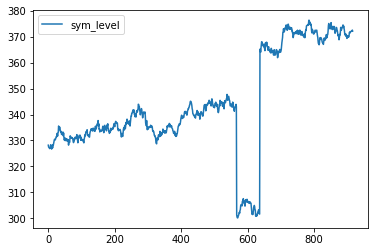

In [293]:
raw_test_data.plot(y='sym_level')

In [294]:
print("baseline_last_trade_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_baseline = model_eval(baseline_last_trade_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_baseline[:5]:
  print(pred)


baseline_last_trade_model
rmse_raw 1.0589019 rmse_pct 0.008415377 rmse_level 2.6530354
first 5 predicted levels:
[330.4770704]
[330.24970864]
[330.20914253]
[330.59423962]
[331.09155396]


In [295]:
print("conv1d_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_conv1d = model_eval(conv1d_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_conv1d[:5]:
  print(pred)


conv1d_model
rmse_raw 1.059249 rmse_pct 0.008417525 rmse_level 2.653622
first 5 predicted levels:
[330.44834766812545]
[330.2210056647227]
[330.18044308257055]
[330.56550669670594]
[331.06277782335377]


In [296]:
print("LSTM_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_LSTM = model_eval(LSTM_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_LSTM[:5]:
  print(pred)


LSTM_model
rmse_raw 1.0606697 rmse_pct 0.008428816 rmse_level 2.6572332
first 5 predicted levels:
[330.3657273114745]
[330.13847001715715]
[330.09786412722895]
[330.48283616188473]
[330.97999512674505]


In [297]:
print("lr_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_lr = model_eval(my_lr_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
print('first 5 predicted levels:')
for pred in preds_level_lr[:5]:
  print(pred)


lr_model
rmse_raw 1.1416467 rmse_pct 0.009072315 rmse_level 2.9010828
first 5 predicted levels:
[333.42806231025725]
[332.7159384967553]
[332.59812555015515]
[332.47572626096684]
[333.5338464211716]


In [298]:
print("maj_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_maj = model_eval(maj_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
for pred in preds_level_maj[:5]:
  print(pred)


maj_model
rmse_raw 1.0598428 rmse_pct 0.008422244 rmse_level 2.655078
[330.40703748979996]
[330.17973784093994]
[330.1391536048997]
[330.52417142929534]
[331.0213864750494]


In [299]:
print("ensStack_model")
rmse_raw, rmse_pct, rmse_level, preds_pct, preds_level_ens = model_eval(ensStack_model, raw_test_data, scaler)
print("rmse_raw", rmse_raw, "rmse_pct", rmse_pct, "rmse_level", rmse_level)
for pred in preds_level_ens[:5]:
  print(pred)


ensStack_model
rmse_raw 1.059798 rmse_pct 0.008421888 rmse_level 2.6549644
[330.4098071044696]
[330.1825089908113]
[330.1419178157948]
[330.5269394473444]
[331.0241601632659]


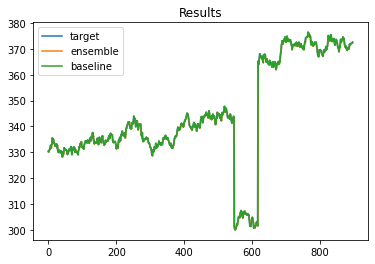

In [300]:
dates = raw_test_data.iloc[window_size:, 0]
target_level = raw_test_data.iloc[window_size:, 1]


plt.plot(range(len(target_level)), target_level, label='target')
plt.plot(range(len(preds_level_ens)), preds_level_ens, label='ensemble') 
plt.plot(range(len(preds_level_baseline)), preds_level_baseline, label='baseline')
plt.legend()
plt.title('Results')
plt.show()


Zoom-in plots

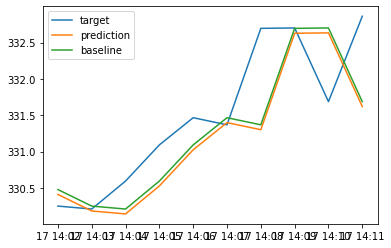

In [301]:
len_data = 10
zoomed_dates = raw_test_data.iloc[window_size:window_size+len_data, 0]
zoomed_target_level = raw_test_data.iloc[window_size:window_size+len_data, 1]
zoomed_preds_level_ens = preds_level_ens[:len_data]
zoomed_preds_level_baseline = preds_level_baseline[:len_data]

plt.plot(zoomed_dates, zoomed_target_level, label='target')
plt.plot(zoomed_dates, zoomed_preds_level_ens, label='prediction')
plt.plot(zoomed_dates, zoomed_preds_level_baseline, label='baseline')
plt.legend()

plt.show()

# Future work to improve the result: 

1.   Use cross-validation (time series) to determine hyperparameters, such as window_size, feature dimensions, number of layers, neurons in the neural networks.
2.   Add more learned models to the ensemble model, such as support vector regressor, xgboost, random forest, etc. 



# Online version of the model
In the current ensemble model, the weights of each model are also trained offline. 

Suppose we have $n$ trained (offline) models (experts). One approach to make it online:

We can formulate the online learning problem as a multi-armed bandit problem: at each time step, we pick an individual model (according to some learned distribution) and observe the cost (between prediction and the actual level); there are several well-known algorithms to achieve this, such as $\epsilon$-greedy, Upper Confidence Bounds (UCB), and Bayesian variants of UCBs. 

There are also online algorithms that can compute weighted average of $n$ experts, see the reference below. 

Reference: 
Cesa-Bianchi, Nicolo, and Gábor Lugosi. Prediction, Learning, and Games. Cambridge university press, 2006.



